# Simple Phase Classifier

Predict the [phase](https://clinicaltrials.gov/ct2/help/phase_desc) from the pubmed abstract of a clinical trial

Uses only one example from each class

In [201]:
from cochranenlp.readers import biviewer

ct_biviewer = biviewer.ClinicalTrialsBiViewer()

def phases_generator():
    for study in ct_biviewer:
        yield study.clinicaltrials.phase
        
phases = [phase for phase in phases_generator()]

df = pd.DataFrame(phases, columns=['phase'])

### Grab an Abstract from Each Phase

In [215]:
phases = ['Phase 0', 'Phase 1', 'Phase 2', 'Phase 3', 'Phase 4', 'Phase 1/Phase 2', 'Phase 2/Phase 3', 'N/A']
            
indexes = [df[df.phase == phase].iloc[0].name for i, phase in zip(range(8), phases)]
abstracts = [ct_biviewer[index].pubmed.text_all()['abstract'] for index in indexes]

### Map Phases Classes to Binary Labels

In [216]:
phase_map = {phase:i for i, phase in enumerate(phases)}

df['label'] = df.phase.map(phase_map)

### Word Clouds

In [203]:
def word_cloud(abstract, axes, title):
    wc = wordcloud.WordCloud().generate(abstract)
    axes.imshow(wc)
    axes.axis('off')
    plt.title(title)

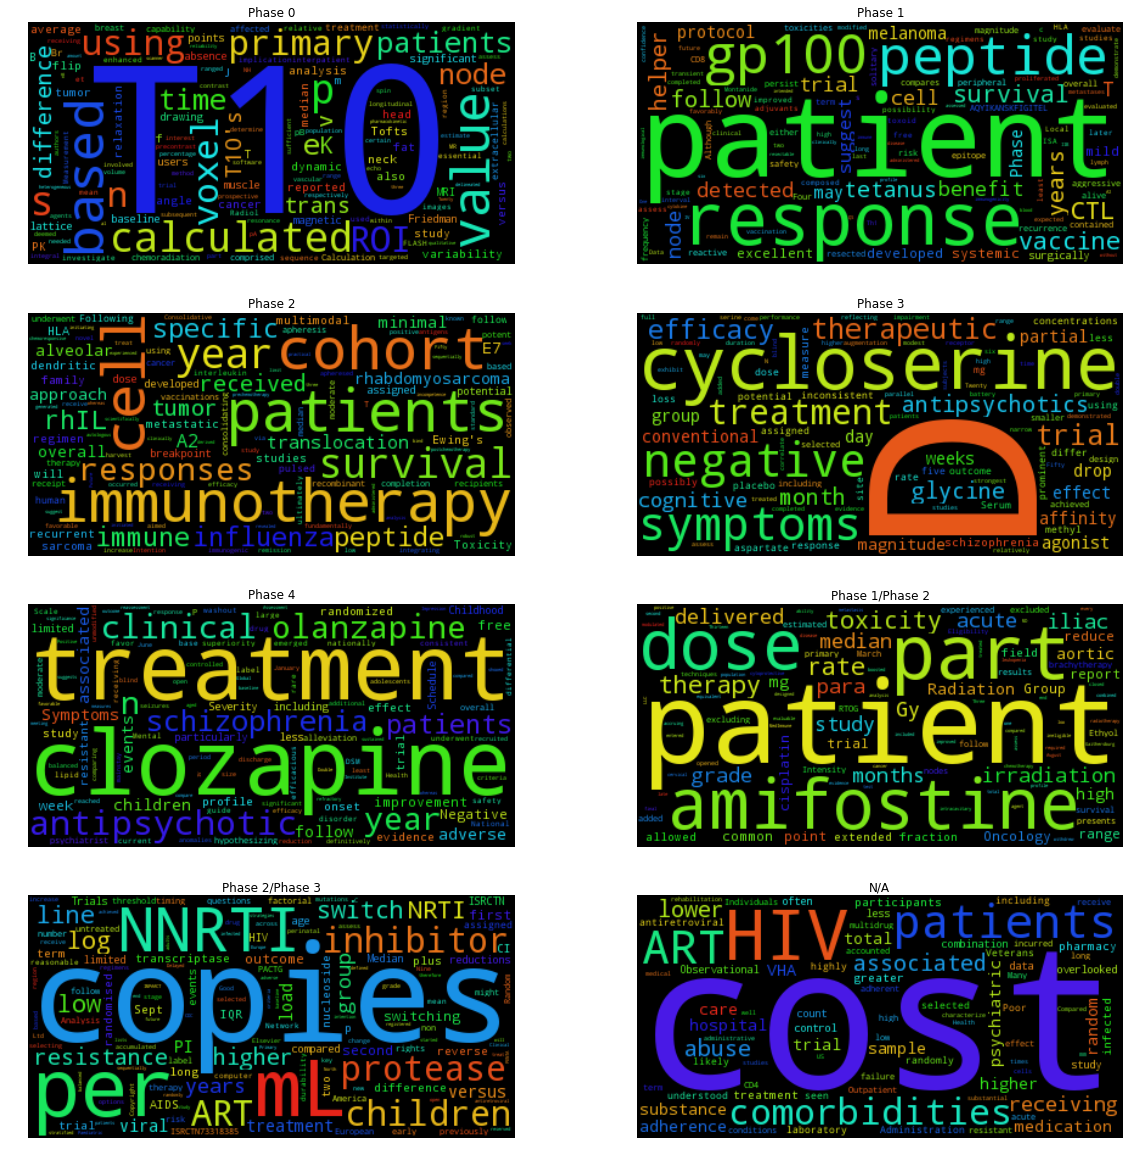

In [204]:
fig = plt.figure(figsize=(20, 20))
plt.clf()

for i, (abstract, title) in enumerate(zip(abstracts, phases), start=1):
    axes = fig.add_subplot(4, 2, i)
    word_cloud(abstract, axes, title)
    
plt.axis('off')
plt.show()

### Fit and Transform

In [205]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

X = vectorizer.fit_transform(abstracts)

X.shape

(8, 846)

### Train on One Example

In [206]:
from sklearn import linear_model

logreg = linear_model.LogisticRegression(C=1e5, multi_class='multinomial', solver='lbfgs')

logreg.fit(X, range(8))

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0)

### Prediction

In [207]:
logreg.predict(X)

array([0, 1, 2, 3, 4, 5, 6, 7])

### Features with Highest Coefficients

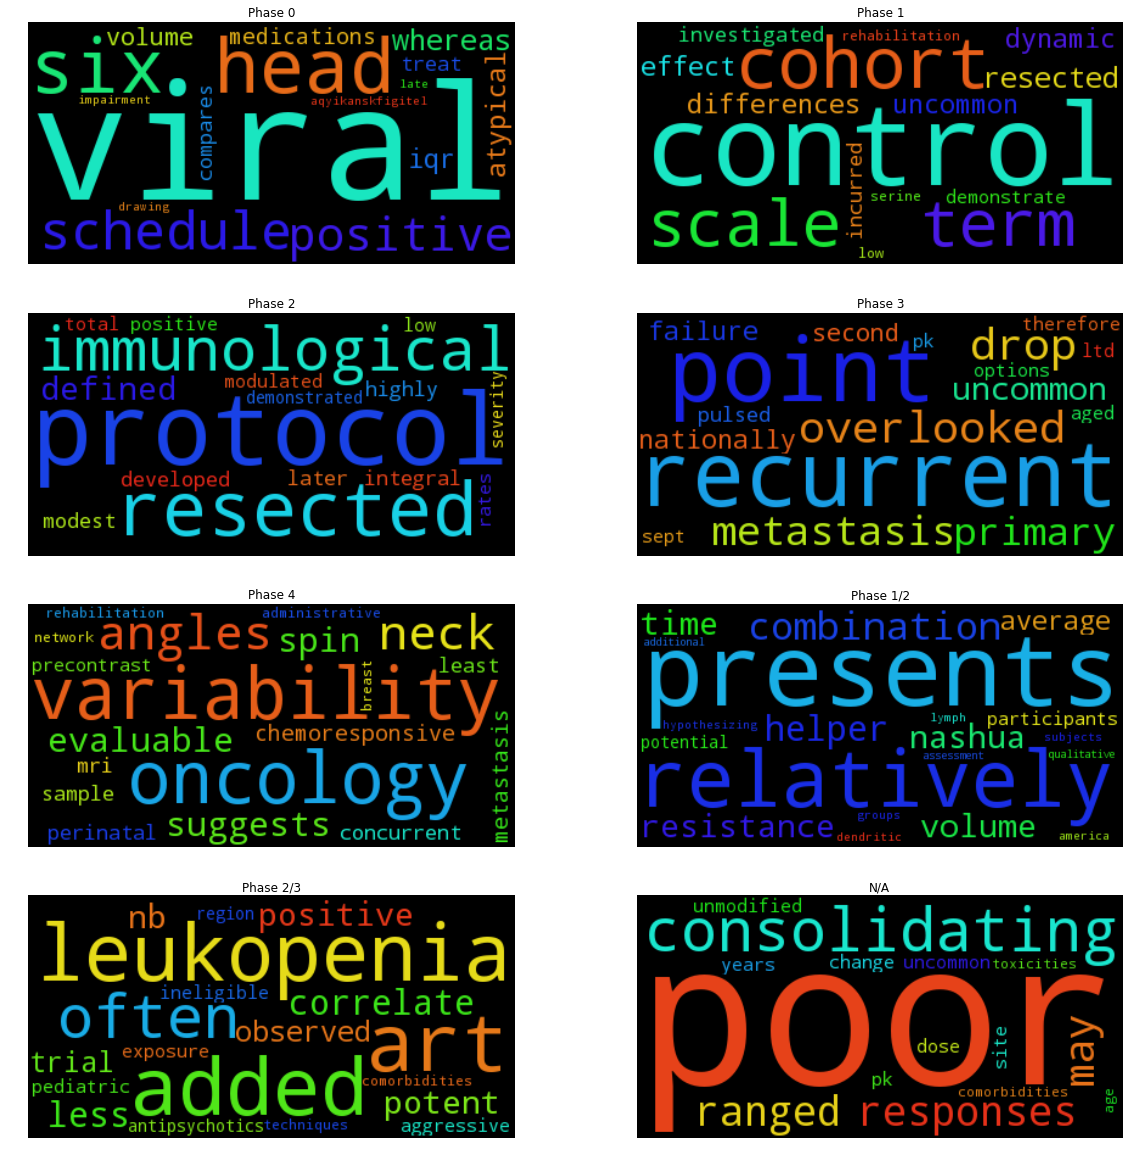

In [208]:
fig = plt.figure(figsize=(20, 20))
plt.clf()

phases = ['Phase 0', 'Phase 1', 'Phase 2', 'Phase 3', 'Phase 4', 'Phase 1/2', 'Phase 2/3', 'N/A']

for i, (weights, title) in enumerate(zip(logreg.coef_, phases), start=1):
    words = sorted(zip(weights, vectorizer.vocabulary_), reverse=True)[:20]
    words = ' '.join(word[1] for word in words)
    
    axes = fig.add_subplot(4, 2, i)
    word_cloud(words, axes, title)
    
plt.axis('off')
plt.show()